<a href="https://colab.research.google.com/github/WaghJagdish/Cosmic-Web-Mapping-GNN/blob/main/TNG100_GNN_Prototype_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TNG100 → GraphSAGE Prototype (Ready-to-run)
**Purpose:** Download a small subset from the public IllustrisTNG API (Snapshot 99, TNG100-1), build a kNN graph, train a tiny GraphSAGE model, and visualize predictions.  
**Designed for:** Google Colab (recommended) or local environment. The notebook includes a fallback synthetic-data mode if API access is unavailable or slow.  
**What you'll get:** a CPU-friendly prototype you can run on Colab to produce plots and metrics for your poster.



## Before you run
- Recommended: open this notebook in **Google Colab** (Runtime -> Change runtime type -> GPU optional).  
- The notebook installs required Python packages when run in Colab. If running locally, make sure you have `python3`, `pip`, and optionally a CUDA-enabled GPU for acceleration.
- Important libraries used: `requests`, `numpy`, `pandas`, `scikit-learn`, `matplotlib`, `torch`, `torch_geometric` (PyG).

If you run into trouble installing `torch_geometric` locally, use Colab and follow the PyG install instructions in the notebook.


In [ ]:
# 2) Inspect HDF5 groups / datasets
import h5py
import os # Import os module to use os.listdir

# Replace this if you already know the exact filename printed above
# The code will auto-pick the first file that looks like groupcat / subhalo / fof_subhalo_tab
files = os.listdir('.') # Initialize 'files' with a list of files in the current directory
candidates = [f for f in files if f.lower().endswith('.hdf5')]
if not candidates:
    raise SystemExit("No .hdf5 files found in current directory. Upload file to Colab first (Files -> Upload).")

fn = candidates[0]   # auto-select the first .hdf5 (you can change index if needed)
print("Inspecting:", fn)

with h5py.File(fn, 'r') as f:
    print("Top-level keys:")
    for k in f.keys():
        print(" -", k)
    # show the 'Subhalo' group keys if present
    if 'Subhalo' in f:
        print("\nSubhalo group keys:")
        for k in f['Subhalo'].keys():
            print("  >", k)
    # show keys for other common groups
    for alt in ['FOF', 'Group', 'Subfind', 'Group', 'Halo']:
        if alt in f:
            print(f"\nFound group: {alt} -> keys: {list(f[alt].keys())[:10]}")

Inspecting: fof_subhalo_tab_099.0 (1).hdf5
Top-level keys:
 - Config
 - Group
 - Header
 - IDs
 - Parameters
 - Subhalo

Subhalo group keys:
  > SubhaloBHMass
  > SubhaloBHMdot
  > SubhaloBfldDisk
  > SubhaloBfldHalo
  > SubhaloCM
  > SubhaloFlag
  > SubhaloGasMetalFractions
  > SubhaloGasMetalFractionsHalfRad
  > SubhaloGasMetalFractionsMaxRad
  > SubhaloGasMetalFractionsSfr
  > SubhaloGasMetalFractionsSfrWeighted
  > SubhaloGasMetallicity
  > SubhaloGasMetallicityHalfRad
  > SubhaloGasMetallicityMaxRad
  > SubhaloGasMetallicitySfr
  > SubhaloGasMetallicitySfrWeighted
  > SubhaloGrNr
  > SubhaloHalfmassRad
  > SubhaloHalfmassRadType
  > SubhaloIDMostbound
  > SubhaloLen
  > SubhaloLenType
  > SubhaloMass
  > SubhaloMassInHalfRad
  > SubhaloMassInHalfRadType
  > SubhaloMassInMaxRad
  > SubhaloMassInMaxRadType
  > SubhaloMassInRad
  > SubhaloMassInRadType
  > SubhaloMassType
  > SubhaloParent
  > SubhaloPos
  > SubhaloSFR
  > SubhaloSFRinHalfRad
  > SubhaloSFRinMaxRad
  > SubhaloSFRinRa

In [ ]:
# Install PyTorch with CUDA 11.8 (compatible with Colab GPU)
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install PyG dependencies for CUDA 11.8 & torch 2.2.0+
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

# Install torch-geometric (PyG)
!pip install -q torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.1/902.1 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:00


In [ ]:
# === Extract sample CSV from your downloaded groupcat HDF5 ===
# Copy-paste and run in Colab. It handles filenames like "fof_subhalo_tab_099.0 (1).hdf5".
import glob, os, h5py, numpy as np, pandas as pd

# 1) locate HDF5 file automatically (prefers groupcat / fof_subhalo names)
cands = [f for f in glob.glob("*.hdf5")]
# prefer names containing 'group' or 'subhalo' or 'fof'
pref = None
for name in cands:
    ln = name.lower()
    if 'groupcat' in ln or 'fof_subhalo' in ln or 'group' in ln or 'subhalo' in ln:
        pref = name
        break
if pref is None and cands:
    pref = cands[0]

if pref is None:
    raise SystemExit("No .hdf5 file found. Upload the downloaded file to Colab (Files -> Upload) first.")

print("Using file:", pref)

# 2) open and extract
with h5py.File(pref, 'r') as f:
    # print header attrs (units, boxsize) if available
    hdr = f.get('Header') or f.get('Header_') or f.get('Config')
    if hdr is not None:
        print("Header keys / attrs (first 20):")
        try:
            for k,v in list(hdr.attrs.items())[:20]:
                print("  ", k, ":", v)
        except Exception:
            pass

    # pick Subhalo group
    if 'Subhalo' not in f:
        raise SystemExit("No 'Subhalo' group found in file. Top keys: " + ", ".join(list(f.keys())))
    sub = f['Subhalo']

    # helper to load dataset safely
    def try_load(grp, names):
        for name in names:
            if name in grp:
                arr = grp[name][:]
                return name, arr
        return None, None

    # datasets we want (ordered lookup)
    pos_name, pos = try_load(sub, ['SubhaloPos','subhalo_pos','Coordinates'])
    vel_name, vel = try_load(sub, ['SubhaloVel','subhalo_vel','Velocity'])
    mass_name, mass = try_load(sub, ['SubhaloMass','SubhaloMassType','SubhaloMassInRad','SubhaloMassInHalfRad'])
    sfr_name, sfr = try_load(sub, ['SubhaloSFR','subhalo_sfr'])
    half_name, half = try_load(sub, ['SubhaloHalfmassRad','SubhaloHalfmassRadType'])
    grnr_name, grnr = try_load(sub, ['SubhaloGrNr','SubhaloGrNrType','SubhaloGrNr'])
    mbid_name, mbid = try_load(sub, ['SubhaloIDMostbound','SubhaloIDMostBound'])

    # determine N and fill fallbacks
    N = None
    for arr in [pos, vel, mass, sfr, half, grnr, mbid]:
        if arr is not None:
            try:
                N = arr.shape[0]
                break
            except Exception:
                continue
    if N is None:
        raise SystemExit("Couldn't infer number of subhalos.")

    # fallback zeros if missing
    if pos is None:
        pos = np.zeros((N,3))
        pos_name = "fallback_pos"
        print("Note: position dataset not found; using zeros fallback.")
    if vel is None:
        vel = np.zeros((N,3))
        vel_name = "fallback_vel"
    if mass is None:
        mass = np.zeros(N)
        mass_name = "fallback_mass"
    if sfr is None:
        sfr = np.zeros(N)
        sfr_name = "fallback_sfr"
    if half is None:
        half = np.zeros(N)
        half_name = "fallback_half"
    if grnr is None:
        grnr = -1 * np.ones(N, dtype=int)
        grnr_name = "fallback_grnr"
    if mbid is None:
        mbid = -1 * np.ones(N, dtype=int)
        mbid_name = "fallback_mbid"

    # build dataframe
    df = pd.DataFrame({
        'id': np.arange(N, dtype=int),
        'x': pos[:,0].astype(float), 'y': pos[:,1].astype(float), 'z': pos[:,2].astype(float),
        'vx': vel[:,0].astype(float), 'vy': vel[:,1].astype(float), 'vz': vel[:,2].astype(float),
        'mass': mass.astype(float),
        'sfr': sfr.astype(float),
        'half_mass_rad': half.astype(float),
        'fof_group': grnr.astype(int),
        'mostbound_id': mbid.astype(int),
    })

print("Total subhalos in file:", len(df))
# 3) sample rows and save CSV (2k default; change sample_n if you want)
sample_n = 2000
sample_n = min(sample_n, len(df))
df_sample = df.sample(sample_n, random_state=42).reset_index(drop=True)
outname = f"tng100_snapshot99_sample_{sample_n}.csv"
df_sample.to_csv(outname, index=False)
print("Saved sample CSV:", outname)
print(df_sample.head())



Using file: fof_subhalo_tab_099.0 (1).hdf5
Header keys / attrs (first 20):
   BoxSize : 75000.0
   FlagDoubleprecision : 0
   Git_commit : b'd203ec8b07c7e2bdda5f608aa0babea46d603699'
   Git_date : b'Thu Apr 7 14:14:27 2016 +0200'
   HubbleParam : 0.6774
   Ngroups_ThisFile : 1
   Ngroups_Total : 6291349
   Nids_ThisFile : 11830481
   Nids_Total : 5263038490
   Nsubgroups_ThisFile : 17185
   Nsubgroups_Total : 4371211
   NumFiles : 448
   Omega0 : 0.3089
   OmegaLambda : 0.6911
   Redshift : 2.220446049250313e-16
   Time : 0.9999999999999998
Total subhalos in file: 17185
Saved sample CSV: tng100_snapshot99_sample_2000.csv
      id            x             y             z          vx          vy  \
0  15238   250.077469  24425.525391  17000.095703  -19.257763  461.422852   
1   1768    22.735140  26673.156250  15499.768555  320.456818  -58.207806   
2  16899  1329.152100  26854.697266  17178.056641 -528.987793 -295.082062   
3  13402   697.622437  26320.591797  17333.763672  -90.602982 -

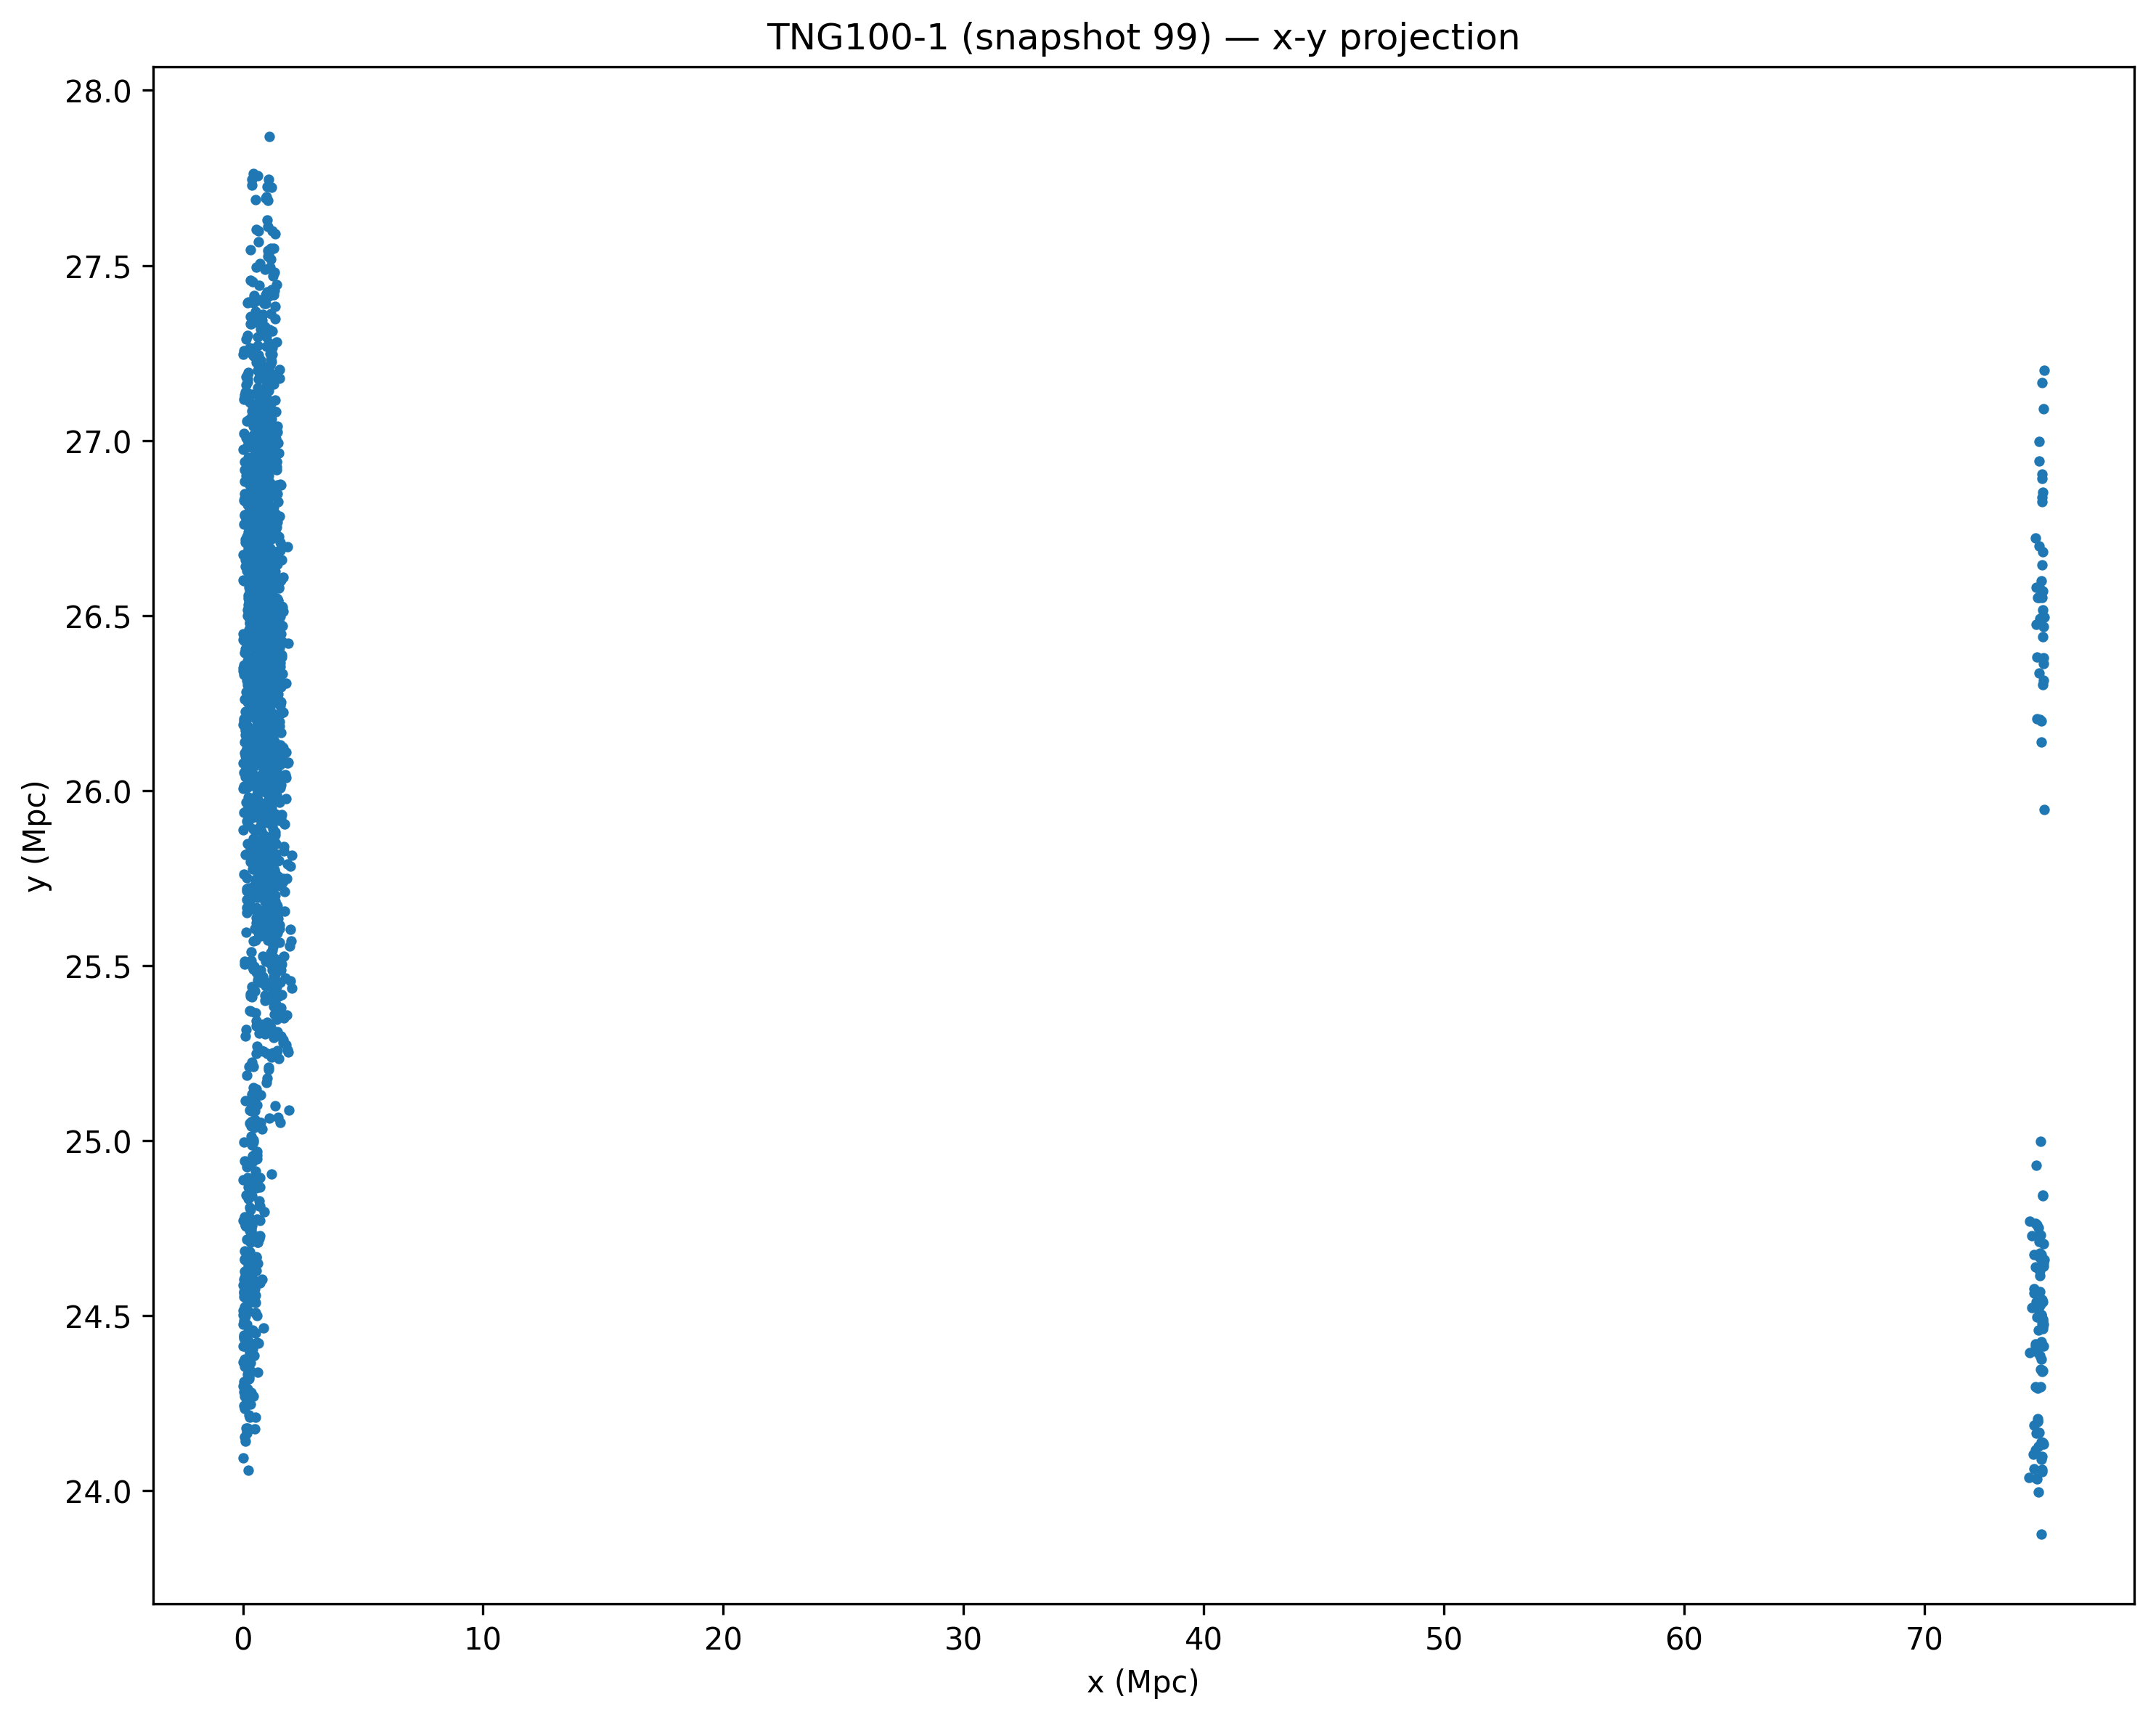

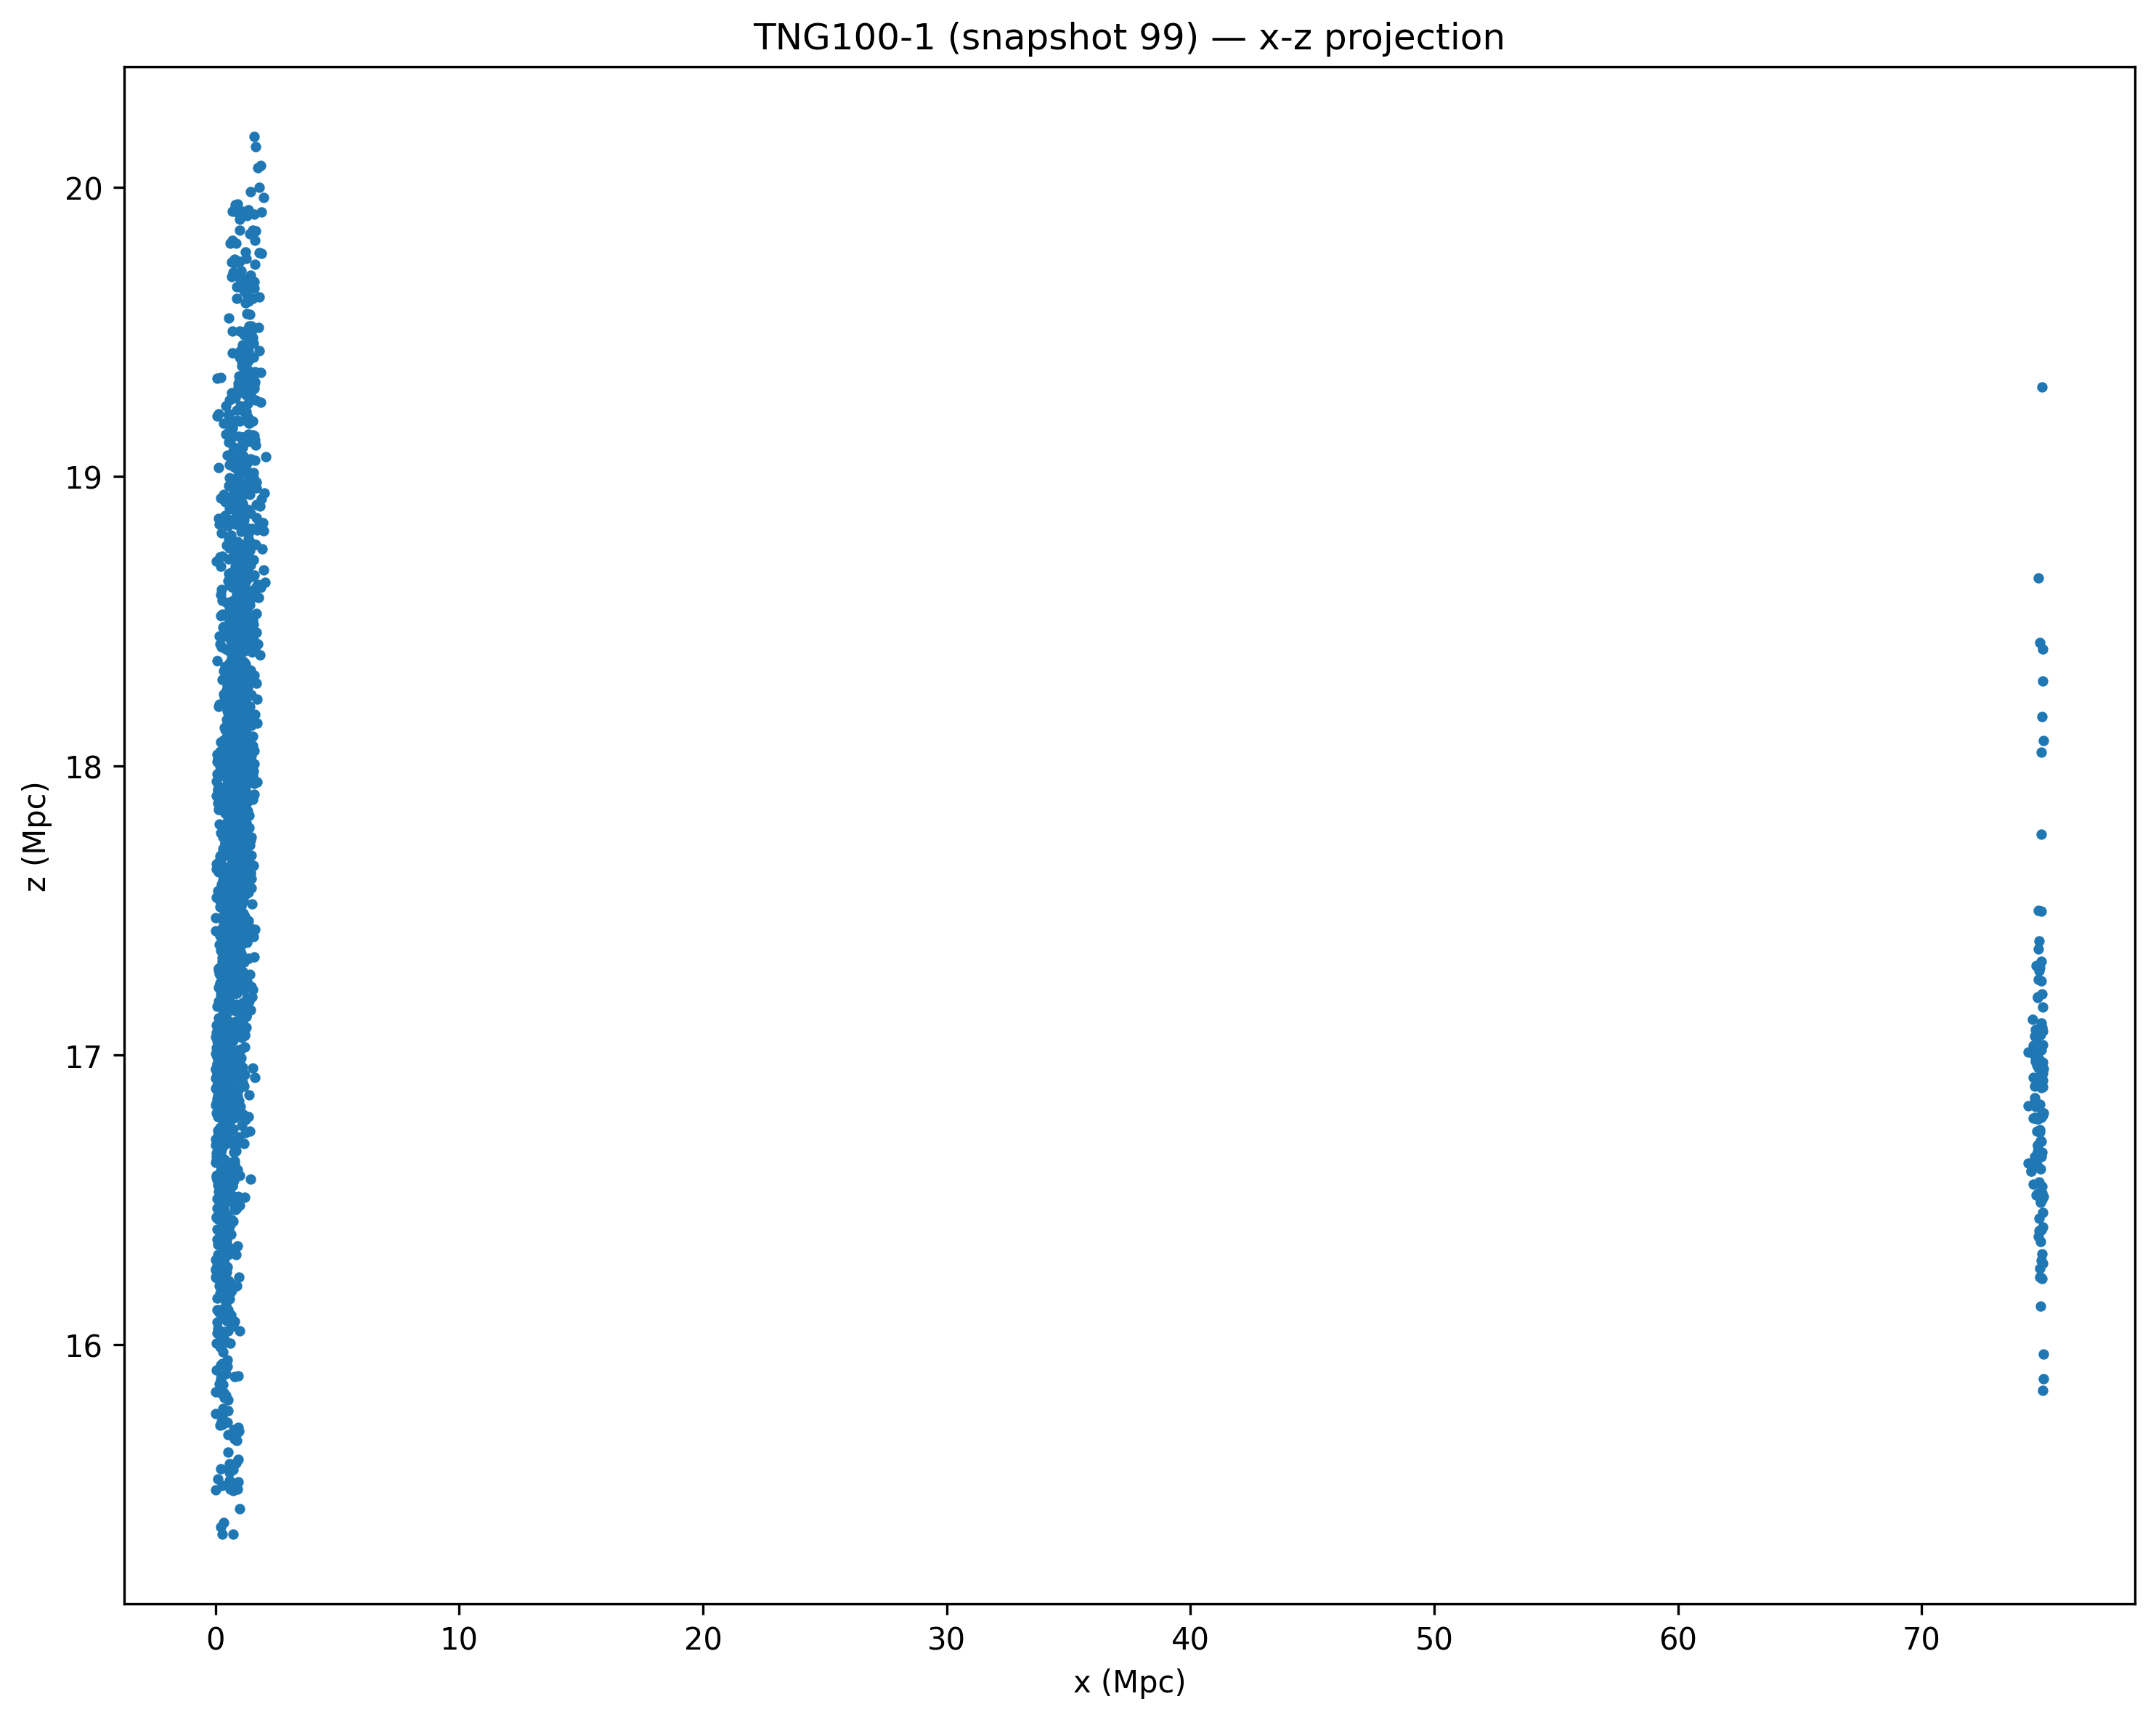

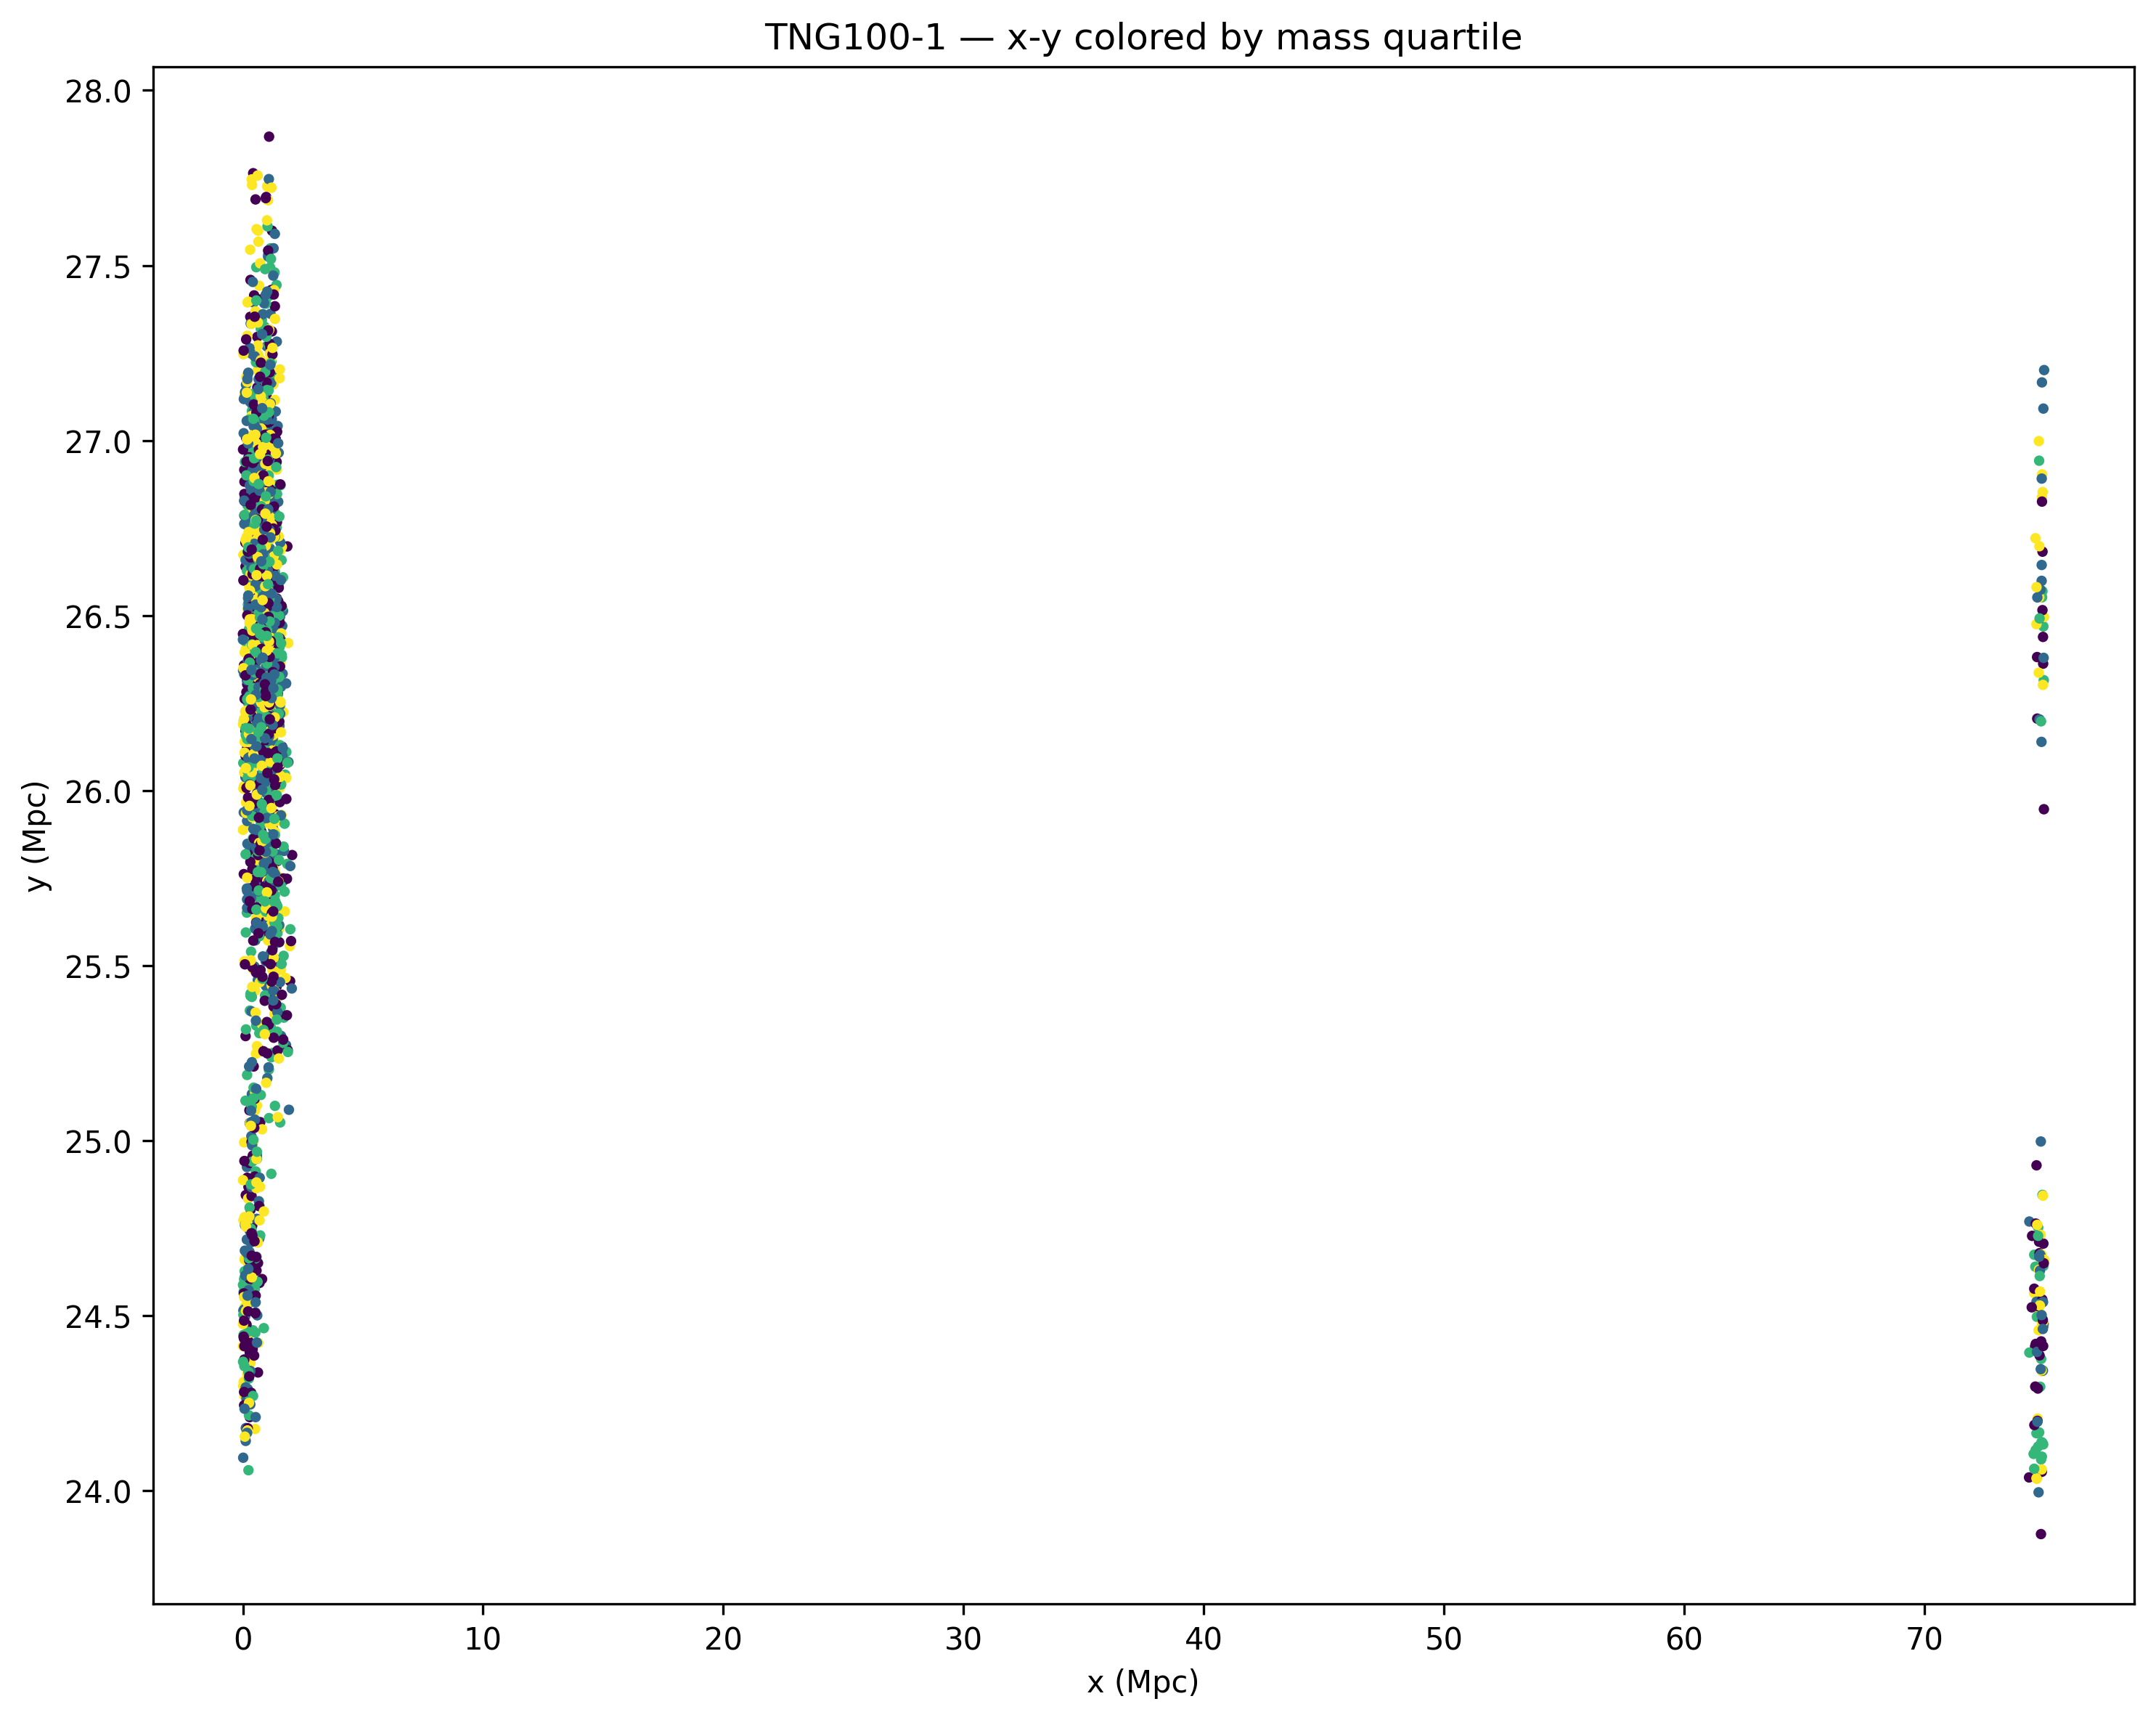

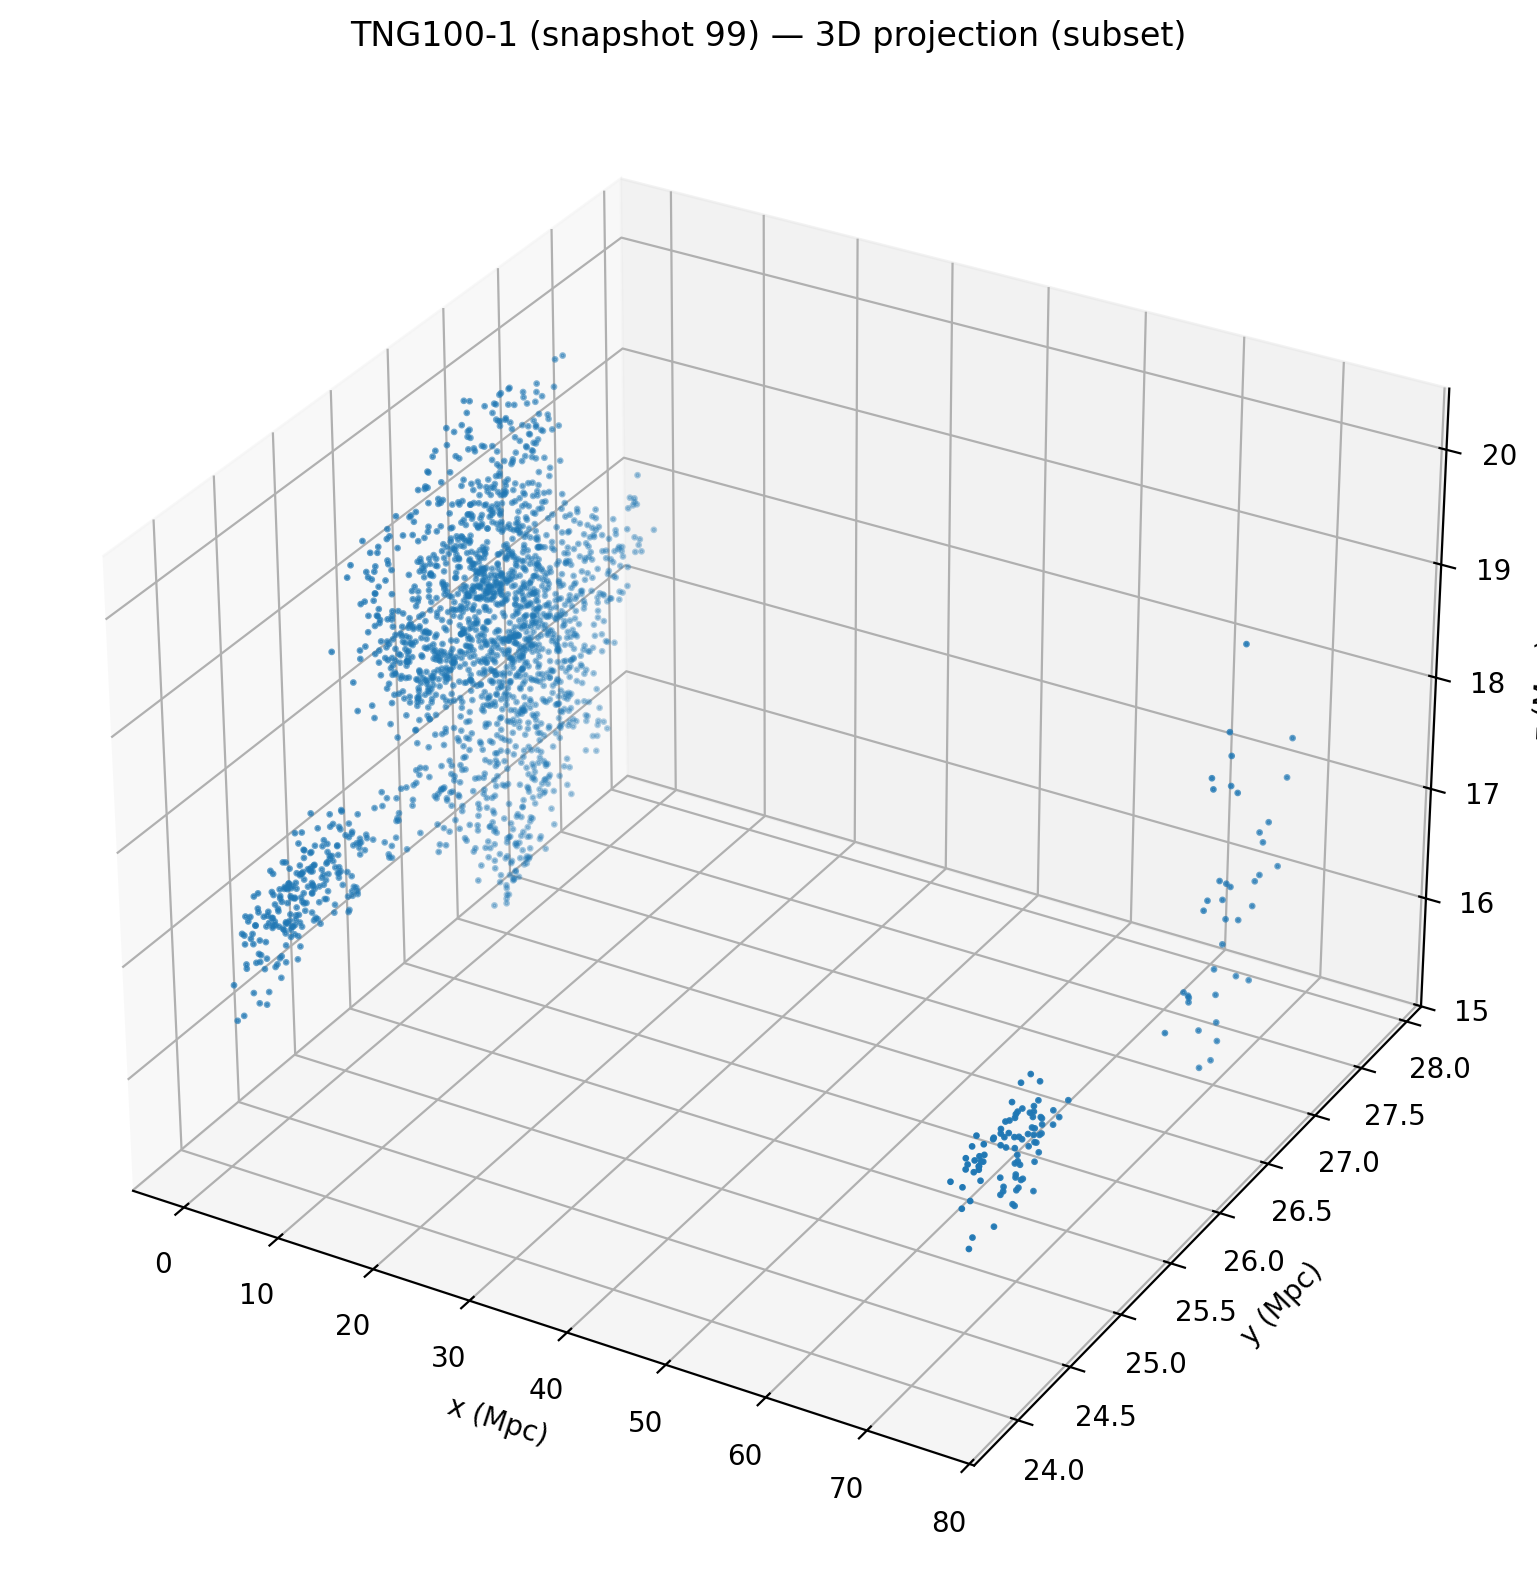

Saved: plot_xy.png, plot_xz.png, plot_xy_mass_quartile.png, plot_3d_subset.png


In [ ]:
# Visualize and save PNGs (2D projections and a density-like 2D with mass color)
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from mpl_toolkits.mplot3d import Axes3D

csvname = "tng100_snapshot99_sample_2000.csv"
df = pd.read_csv(csvname)

# Normalize positions to Mpc (optional): file positions are kpc, convert to Mpc
df['x_Mpc'] = df['x'] / 1000.0
df['y_Mpc'] = df['y'] / 1000.0
df['z_Mpc'] = df['z'] / 1000.0

# 2D scatter x-y
plt.figure(figsize=(10,8), dpi=300)
plt.scatter(df['x_Mpc'], df['y_Mpc'], s=6)
plt.xlabel('x (Mpc)'); plt.ylabel('y (Mpc)')
plt.title('TNG100-1 (snapshot 99) — x-y projection')
plt.tight_layout()
plt.savefig('plot_xy.png', dpi=300)
plt.show()

# 2D scatter x-z
plt.figure(figsize=(10,8), dpi=300)
plt.scatter(df['x_Mpc'], df['z_Mpc'], s=6)
plt.xlabel('x (Mpc)'); plt.ylabel('z (Mpc)')
plt.title('TNG100-1 (snapshot 99) — x-z projection')
plt.tight_layout()
plt.savefig('plot_xz.png', dpi=300)
plt.show()

# Colored by mass quartile
mass_q = np.digitize(df['mass'], np.quantile(df['mass'], [0.25,0.5,0.75]))
plt.figure(figsize=(10,8), dpi=300)
plt.scatter(df['x_Mpc'], df['y_Mpc'], s=6, c=mass_q)
plt.xlabel('x (Mpc)'); plt.ylabel('y (Mpc)')
plt.title('TNG100-1 — x-y colored by mass quartile')
plt.tight_layout()
plt.savefig('plot_xy_mass_quartile.png', dpi=300)
plt.show()

# 3D scatter (sparse sampling for clarity)
sample3d = df.sample(min(2000, len(df)), random_state=1)
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample3d['x_Mpc'], sample3d['y_Mpc'], sample3d['z_Mpc'], s=2)
ax.set_xlabel('x (Mpc)'); ax.set_ylabel('y (Mpc)'); ax.set_zlabel('z (Mpc)')
ax.set_title('TNG100-1 (snapshot 99) — 3D projection (subset)')
plt.tight_layout()
plt.savefig('plot_3d_subset.png', dpi=300)
plt.show()

print("Saved: plot_xy.png, plot_xz.png, plot_xy_mass_quartile.png, plot_3d_subset.png")


In [ ]:
# --- Plan A: install torch 2.2.0+cu118 and PyG wheels that match it ---
# Restart runtime before running this. Then run the following single cell.

!pip install -q --upgrade pip

# install a torch build that exists on the index
!pip install -q torch==2.2.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118

# install PyG dependency wheels for torch 2.2.0+cu118
!pip install -q pyg-lib==0.4.0 -f https://data.pyg.org/whl/torch-2.2.0+cu118.html || true
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

# install main torch-geometric
!pip install -q torch-geometric
# install helper libs
!pip install -q scikit-learn matplotlib h5py pandas


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

Saved graph_data_npy.npz (edges, features, labels)
Saved graph_data.pt (PyG Data)


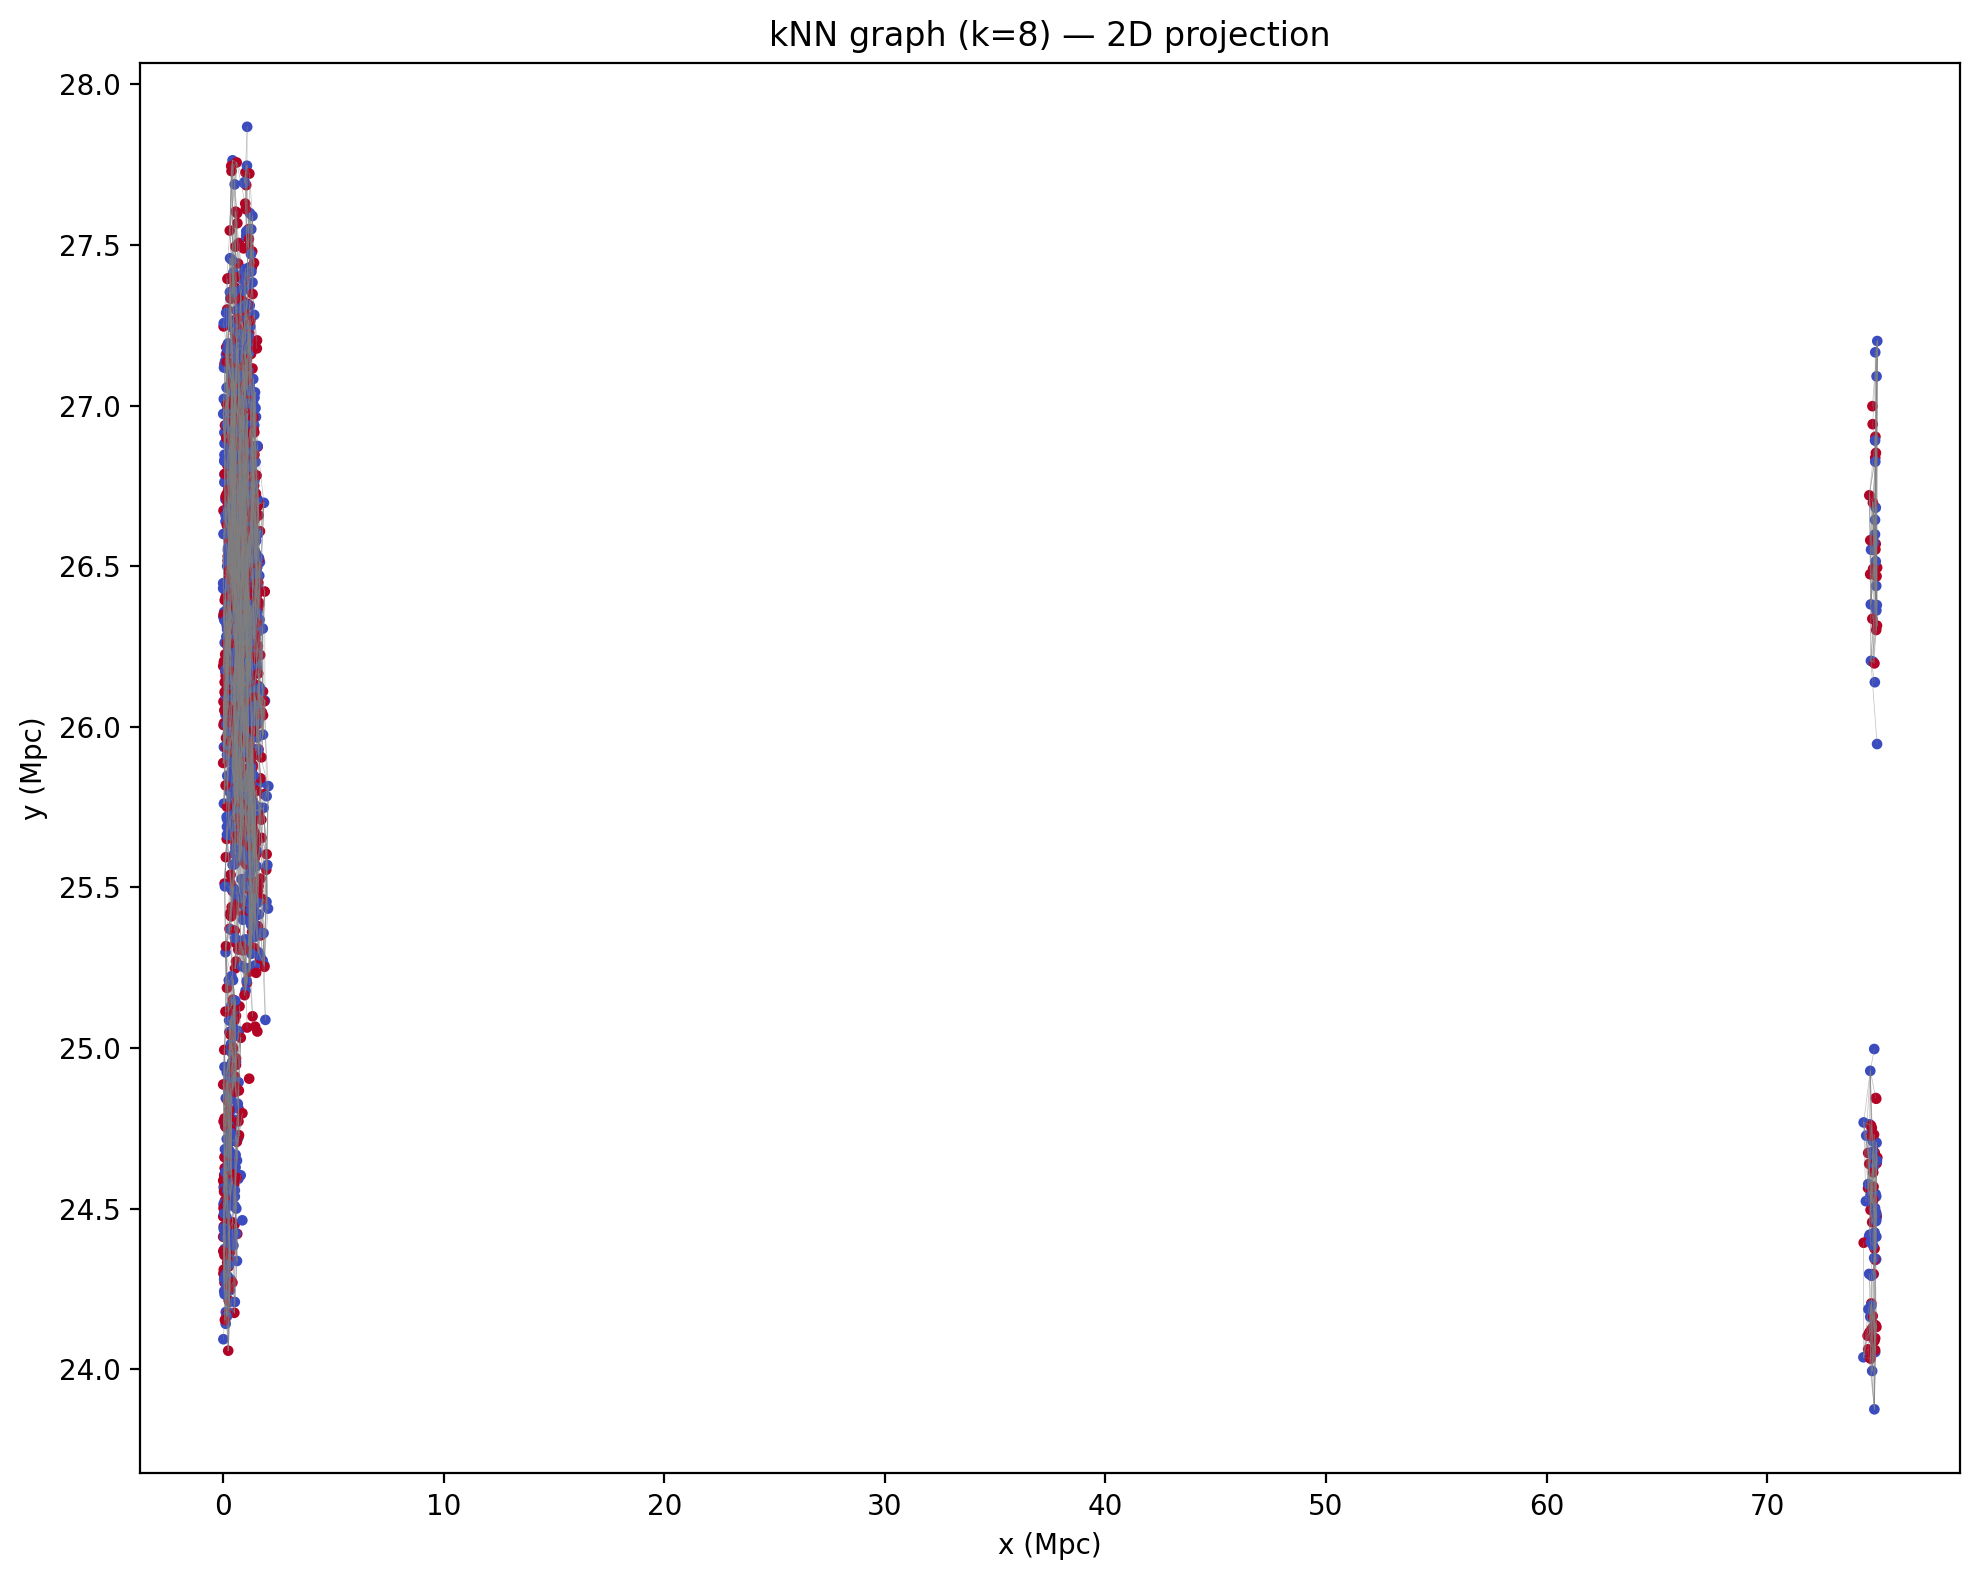

Saved knn_graph.png


In [ ]:
# Build kNN graph, save visualization and edge/features files
import pandas as pd, numpy as np, os
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import torch

csvname = "tng100_snapshot99_sample_2000.csv"
if not os.path.exists(csvname):
    raise SystemExit("CSV not found. Run the extraction cell first.")

df = pd.read_csv(csvname)

# positions in kpc and Mpc
pos_kpc = df[['x','y','z']].values.astype(np.float32)
pos_mpc = pos_kpc / 1000.0

# node features: pos(Mpc), log10(mass+eps), sfr
eps = 1e-9
mass = df['mass'].fillna(0).values.astype(np.float32).reshape(-1,1)
mass_log = np.log10(mass + eps)
sfr = df['sfr'].fillna(0).values.astype(np.float32).reshape(-1,1)
X = np.hstack([pos_mpc, mass_log, sfr])

# build kNN graph
k = 8
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(pos_kpc)
dist, idx = nbrs.kneighbors(pos_kpc)

edges = []
for i, neigh in enumerate(idx):
    for j in neigh[1:]:   # skip self
        edges.append((i, int(j)))
edges = np.array(edges, dtype=np.int64)  # shape (E,2)

# save numpy edge list + features
np.savez_compressed("graph_data_npy.npz", edges=edges, features=X, labels=(df['mass']>df['mass'].median()).astype(int).values)
print("Saved graph_data_npy.npz (edges, features, labels)")

# try to save PyG Data too (if torch_geometric exists)
try:
    from torch_geometric.data import Data
    edge_index = torch.tensor(edges.T, dtype=torch.long)
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor((df['mass']>df['mass'].median()).astype(int).values, dtype=torch.long)
    pdg = Data(x=x, edge_index=edge_index, y=y)
    torch.save(pdg, "graph_data.pt")
    print("Saved graph_data.pt (PyG Data)")
except Exception as e:
    print("PyG save skipped (not installed or error):", e)

# Visualization (2D x-y projection)
pts = pos_mpc[:, :2]   # x,y in Mpc
plt.figure(figsize=(10,8), dpi=200)
max_edges = min(len(edges), 6000)
for a,b in edges[:max_edges]:
    xa, ya = pts[a]; xb, yb = pts[b]
    plt.plot([xa, xb], [ya, yb], linewidth=0.25, alpha=0.5, color='gray')
plt.scatter(pts[:,0], pts[:,1], s=8, c=(df['mass']>df['mass'].median()).astype(int), cmap='coolwarm')
plt.xlabel('x (Mpc)'); plt.ylabel('y (Mpc)')
plt.title(f'kNN graph (k={k}) — 2D projection')
plt.tight_layout()
plt.savefig("knn_graph.png", dpi=300)
plt.show()
print("Saved knn_graph.png")


In [ ]:
# FALLBACK TRAINING CELL (Colab) — sklearn MLP on GraphSAGE-like aggregated features
import os, numpy as np, pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import joblib

csvname = "tng100_snapshot99_sample_2000.csv"
if not os.path.exists(csvname):
    raise SystemExit(f"CSV '{csvname}' not found. Run extraction cell first and ensure file is in Colab Files.")

df = pd.read_csv(csvname)
print("Rows:", len(df))

# sample up to 2000 (if your file is larger)
sample_n = min(2000, len(df))
if len(df) > sample_n:
    df = df.sample(sample_n, random_state=42).reset_index(drop=True)
    print(f"Sampled {sample_n} rows")

# Build base features: pos (Mpc), log mass, sfr
pos_kpc = df[['x','y','z']].values.astype(float)
pos_mpc = pos_kpc / 1000.0
mass = df['mass'].fillna(0).values.astype(float)
sfr = df['sfr'].fillna(0).values.astype(float)
mass_log = np.log10(mass + 1e-8).reshape(-1,1)
sfr_col = sfr.reshape(-1,1)
X_base = np.hstack([pos_mpc, mass_log, sfr_col])

# kNN (k=8)
k = 8
nbrs = NearestNeighbors(n_neighbors=k+1).fit(pos_kpc)
_, idx = nbrs.kneighbors(pos_kpc)
neighbor_idx = idx[:,1:]  # remove self

# neighbor mean features
neighbor_means = np.array([X_base[neighbor_idx[i]].mean(axis=0) for i in range(len(X_base))])

# aggregated features: [self | neighbor_mean]
X_agg = np.hstack([X_base, neighbor_means])

# demo labels: binary by mass median (replace with real LSS labels later)
y = (mass > np.median(mass)).astype(int)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_agg, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# MLP classifier
clf = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)
print(classification_report(y_test, y_pred, digits=3))

# Save prediction plot (x-y projection)
y_all_pred = clf.predict(scaler.transform(X_agg))
plt.figure(figsize=(8,6), dpi=150)
plt.scatter(df['x']/1000.0, df['y']/1000.0, c=y_all_pred, s=8, cmap='coolwarm')
plt.xlabel('x (Mpc)'); plt.ylabel('y (Mpc)')
plt.title('MLP (GraphSAGE-like aggregated features) predictions')
plt.tight_layout()
out_plot = 'simple_mlp_graphsage_pred_xy.png'
plt.savefig(out_plot, dpi=300)
plt.close()
print("Saved plot:", out_plot)

# Save model + scaler
joblib.dump(clf, 'mlp_graphsage_model.joblib')
joblib.dump(scaler, 'mlp_graphsage_scaler.joblib')
print("Saved model & scaler: mlp_graphsage_model.joblib, mlp_graphsage_scaler.joblib")

# Print sample rows with predictions
sample_preview = df[['x','y','z','mass','sfr']].copy()
sample_preview['pred'] = y_all_pred
print(sample_preview.head().to_string(index=False))

# Files to download: simple_mlp_graphsage_pred_xy.png, mlp_graphsage_model.joblib


Rows: 2000
Test accuracy: 0.9875
              precision    recall  f1-score   support

           0      0.985     0.990     0.988       201
           1      0.990     0.985     0.987       199

    accuracy                          0.988       400
   macro avg      0.988     0.987     0.987       400
weighted avg      0.988     0.988     0.987       400

Saved plot: simple_mlp_graphsage_pred_xy.png
Saved model & scaler: mlp_graphsage_model.joblib, mlp_graphsage_scaler.joblib
          x            y            z     mass  sfr  pred
 250.077469 24425.525391 17000.095703 0.012134  0.0     0
  22.735140 26673.156250 15499.768555 0.221947  0.0     1
1329.152100 26854.697266 17178.056641 0.010111  0.0     0
 697.622437 26320.591797 17333.763672 0.014662  0.0     0
1357.412720 26733.232422 17335.281250 0.012134  0.0     0


Loaded graph_data.pt (PyG Data).
Device: cuda | Nodes: 2000 Edges: 16000
Epoch 001 Loss 1.6087 TrainAcc 0.5100 TestAcc 0.4875
Epoch 010 Loss 0.9177 TrainAcc 0.5913 TestAcc 0.6250
Epoch 020 Loss 0.8639 TrainAcc 0.5056 TestAcc 0.5050
Epoch 030 Loss 0.7918 TrainAcc 0.5094 TestAcc 0.5075
Epoch 040 Loss 0.7696 TrainAcc 0.5844 TestAcc 0.5725
Epoch 050 Loss 0.7089 TrainAcc 0.7244 TestAcc 0.7100
Epoch 060 Loss 0.6971 TrainAcc 0.7713 TestAcc 0.7625
Epoch 070 Loss 0.6753 TrainAcc 0.7800 TestAcc 0.7850
Epoch 080 Loss 0.6554 TrainAcc 0.7788 TestAcc 0.7725
Epoch 090 Loss 0.6424 TrainAcc 0.6069 TestAcc 0.6225
Epoch 100 Loss 0.6428 TrainAcc 0.8837 TestAcc 0.8700
Epoch 110 Loss 0.6259 TrainAcc 0.7569 TestAcc 0.7575
Epoch 120 Loss 0.6202 TrainAcc 0.8950 TestAcc 0.9100
Epoch 130 Loss 0.5899 TrainAcc 0.8219 TestAcc 0.8375
Epoch 140 Loss 0.5559 TrainAcc 0.7944 TestAcc 0.8000
Epoch 150 Loss 0.5607 TrainAcc 0.8181 TestAcc 0.8250
Saved GNN model: gnn_sage_model.pth  Best test acc: 0.9099999666213989
Final Te

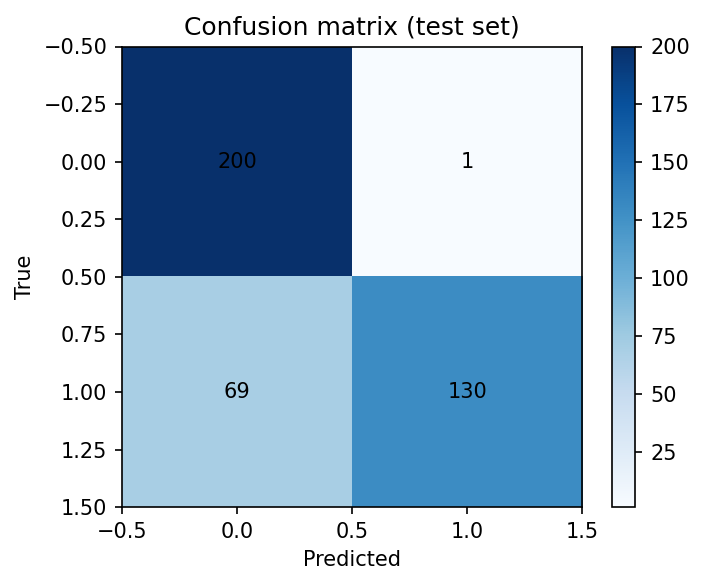

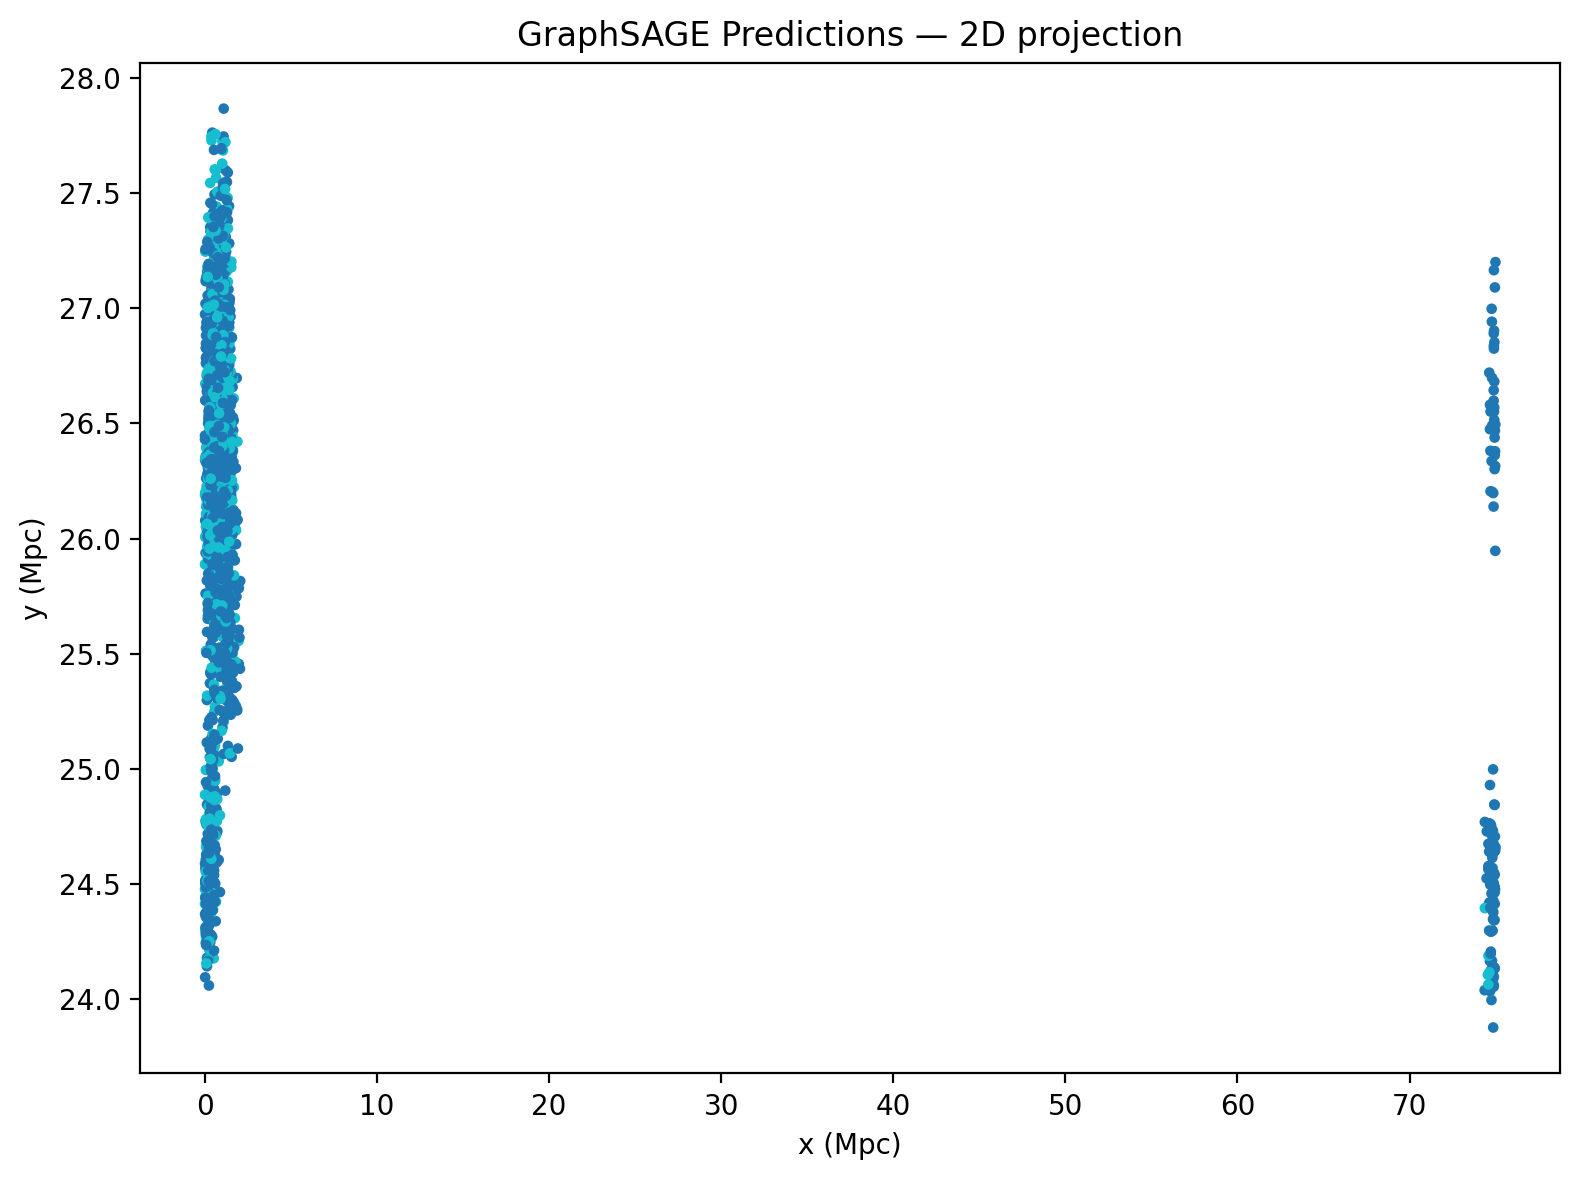

In [ ]:
# Full GraphSAGE training cell (PyG). Auto-detects data from graph_data.pt, graph_data_npy.npz or CSV.
# Produces: gnn_sage_model.pth, preds plot, confusion matrix, explainer report.
# Requires: torch, torch_geometric, sklearn, matplotlib, pandas, numpy

!pip install 'numpy<2.0.0' # Downgrade numpy to resolve incompatibility with PyTorch/PyG

import os, sys, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Try to load PyG Data if present
data = None
if os.path.exists("graph_data.pt"):
    try:
        from torch_geometric.data import Data
        data = torch.load("graph_data.pt")
        print("Loaded graph_data.pt (PyG Data).")
    except Exception as e:
        print("graph_data.pt exists but failed to load:", e)

# else try numpy archive
if data is None and os.path.exists("graph_data_npy.npz"):
    z = np.load("graph_data_npy.npz", allow_pickle=True)
    edges = z["edges"]         # shape (E,2)
    features = z["features"]   # shape (N, F)
    labels = z["labels"]       # shape (N,)
    print("Loaded graph_data_npy.npz (edges/features/labels).")
    # convert to PyG Data
    try:
        from torch_geometric.data import Data
        import torch
        x = torch.tensor(features, dtype=torch.float)
        edge_index = torch.tensor(edges.T, dtype=torch.long)
        y = torch.tensor(labels, dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        print("Converted to PyG Data.")
    except Exception as e:
        print("Could not convert numpy data to PyG Data:", e)
        data = None

# fallback: load CSV and build kNN graph
if data is None and os.path.exists("tng100_snapshot99_sample_2000.csv"):
    print("Building graph from CSV fallback.")
    from sklearn.neighbors import NearestNeighbors
    import torch
    df = pd.read_csv("tng100_snapshot99_sample_2000.csv")
    # features: pos(Mpc) + log mass + sfr  (same as used before)
    pos_kpc = df[['x','y','z']].values.astype(np.float32)
    pos_mpc = pos_kpc / 1000.0
    mass = df['mass'].fillna(0).values.astype(np.float32).reshape(-1,1)
    mass_log = np.log10(mass + 1e-9)
    sfr = df['sfr'].fillna(0).values.astype(np.float32).reshape(-1,1)
    X = np.hstack([pos_mpc, mass_log, sfr])
    # normalize
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    k = 8
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(pos_kpc)
    _, idx = nbrs.kneighbors(pos_kpc)
    edges = []
    for i,nbs in enumerate(idx):
        for j in nbs[1:]:
            edges.append([i,int(j)])
    edges = np.array(edges, dtype=np.int64)
    x = torch.tensor(Xs, dtype=torch.float)
    edge_index = torch.tensor(edges.T, dtype=torch.long)
    # labels: we may have synthetic labels, but if real labels exist replace here
    if 'lss_label' in df.columns:
        y = torch.tensor(df['lss_label'].values, dtype=torch.long)
        print("Using LSS labels from CSV (lss_label).")
    else:
        y = torch.tensor(((df['mass'] > df['mass'].median()).astype(int)).values, dtype=torch.long)
        print("Using mass-median synthetic labels (replace with real LSS labels when available).")
    from torch_geometric.data import Data
    data = Data(x=x, edge_index=edge_index, y=y)
    print("Built PyG Data from CSV:", data)

if data is None:
    raise SystemExit("No graph data found. Upload graph_data.pt or graph_data_npy.npz or tng100_snapshot99_sample_2000.csv")

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
print("Device:", device, "| Nodes:", data.num_nodes, "Edges:", data.num_edges)

# Train / val partition (node classification)
num_nodes = data.num_nodes
all_idx = np.arange(num_nodes)
train_idx, test_idx = train_test_split(all_idx, test_size=0.20, random_state=42, stratify=data.y.cpu().numpy())
train_idx = torch.tensor(train_idx, dtype=torch.long).to(device)
test_idx = torch.tensor(test_idx, dtype=torch.long).to(device)

# GraphSAGE model (full-batch)
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch.nn as nn

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.drop = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.drop, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.lin(x)
        return x

model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=64, out_channels=len(torch.unique(data.y))).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop (full-batch)
best_test_acc = 0.0
best_state = None
epochs = 150
for epoch in range(1, epochs+1):
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    opt.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            logits = model(data.x, data.edge_index)
            preds = logits.argmax(dim=1)
            train_acc = (preds[train_idx] == data.y[train_idx]).float().mean().item()
            test_acc = (preds[test_idx] == data.y[test_idx]).float().mean().item()
        print(f"Epoch {epoch:03d} Loss {loss.item():.4f} TrainAcc {train_acc:.4f} TestAcc {test_acc:.4f}")
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_state = model.state_dict()

# Save best model
if best_state is not None:
    torch.save(best_state, "gnn_sage_model.pth")
else:
    torch.save(model.state_dict(), "gnn_sage_model.pth")
print("Saved GNN model: gnn_sage_model.pth  Best test acc:", best_test_acc)

# Evaluate & save metrics
model.load_state_dict(torch.load("gnn_sage_model.pth"))
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index).cpu().numpy()
preds = logits.argmax(axis=1)
y_true = data.y.cpu().numpy()

# Compute metrics for test set
test_idx_cpu = test_idx.cpu().numpy()
test_preds = preds[test_idx_cpu]
test_true = y_true[test_idx_cpu]
acc = accuracy_score(test_true, test_preds)
f1 = f1_score(test_true, test_preds, average='macro')
print("Final Test Accuracy:", acc, "Macro-F1:", f1)
print(classification_report(test_true, test_preds, digits=3))

# Confusion matrix & plotting
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(5,4), dpi=150)
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar(); plt.title("Confusion matrix (test set)")
plt.xlabel("Predicted"); plt.ylabel("True")
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center', color='black')
plt.tight_layout(); plt.savefig("confusion_matrix.png", dpi=300)
print("Saved confusion_matrix.png")

# Prediction scatter (2D x-y projection)
import matplotlib.pyplot as plt
if 'x_Mpc' in locals():
    # if CSV path used earlier with pos in Mpc, use that
    xs = (data.x[:,0].cpu().numpy())
    ys = (data.x[:,1].cpu().numpy())
else:
    # assume first two columns are positions in Mpc (as we built above)
    xs = data.x[:,0].cpu().numpy()
    ys = data.x[:,1].cpu().numpy()

plt.figure(figsize=(8,6), dpi=200)
plt.scatter(xs, ys, c=preds, s=8, cmap='tab10')
plt.xlabel("x (Mpc)"); plt.ylabel("y (Mpc)"); plt.title("GraphSAGE Predictions — 2D projection")
plt.tight_layout(); plt.savefig("gnn_predictions_xy.png", dpi=300)
print("Saved gnn_predictions_xy.png")

# Quick interpretability with GNNExplainer on a sample node
try:
    from torch_geometric.nn import GNNExplainer
    explainer = GNNExplainer(model, epochs=200)
    node_idx = int(data.num_nodes // 2)  # middle node
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
    ax = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y.cpu().numpy())
    plt.savefig("gnn_explainer_subgraph.png", dpi=300)
    print("Saved gnn_explainer_subgraph.png")
except Exception as e:
    print("GNNExplainer not available or failed:", e)

print("All done. Files saved: gnn_sage_model.pth, gnn_predictions_xy.png, confusion_matrix.png, (gnn_explainer_subgraph.png if created).")


## Notes & Next Steps
- For a fully supervised pipeline, per-galaxy labels (Void/Wall/Filament/Node) are generated from the simulation's dark-matter field using geometry-based tools (e.g., watershed, NEXUS+). That step requires the dense DM grid and more compute. For the poster, showcasing the prototype + clear plan for full labeling is sufficient.
- To improve realism: create "mock observed catalogs" by adding magnitude limits and redshift errors to the selected subhalo catalog (forward modeling).
- For larger experiments, use an HPC GPU node (A100/H100) or Google Cloud / Colab Pro GPU. Use NeighborLoader for scalable mini-batch training on very large graphs.
- If you want, I can convert this notebook into a downloadable `.ipynb` file and provide a direct link.
